In [1]:
from IPython.display import Image,HTML,display
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors
from matplotlib.pyplot import figure
from scipy.signal import savgol_filter as savgol
import seaborn as sns
sns.set_style('whitegrid')
from scipy.optimize import minimize
Image(url= "https://badenlabdotorg.files.wordpress.com/2018/03/cropped-lab-logo_banner21.png", width=1000, height=1000)

In [15]:
# Setting global parameters

# Spectrometer recording traces, the directory has to be modified to its new location
os.chdir(r"C:\Users\Maxime\Documents\GitHub\Multi-Chromatic-Stimulator\Spectrum Calibration\Spectrometer Recording") 


nLoops = 5           # Number of recording loop (5 in the submitted example)
nLED = 4             # Number of LED (4 in our tested stimulator)
nPoints = 100        # Number of recording point per LED (100 in the current example (from 1 to 100% light intensity with an increment of 1))
FirstPoint = 33      # Start of the recording point 

PMT1_min = 520       # PMT 1 bandpass filter low wavelength
PMT1_max = 550       # PMT 1 bandpass filter high wavelength
PMT2_min = 615       # PMT 2 bandpass filter low wavelength
PMT2_max = 645       # PMT 2 bandpass filter high wavelength



''' Here we defined the max absorbance for each cone opsin present in the Zebrafish. The following values are taken from 
Allison et al (Visual pigment composition in zebrafish:Evidence for a rhodopsin–porphyropsin interchange system, 2004)    '''
peakwvss = [565, 482, 411, 361]          # Peak opsin absorbance wavelengths in nm(R,G,B,UV)



SpectraNumber = nLoops*nLED*nPoints      # Total recording point number
SpectraStart = 19                        # First recording point (in our example: Spectrum000000019)
lenSpectra = 9                           # Length of the file string number (9 for ThorLab Spectrometer)

SpectraRange = (300,700)                 # Spectrum Range in nm displayed on the various graph 
FigureSize = (15,10)                     # Set the size of all spectra figures
FigureFontSize = 20                      # Set the font size for spectra figure labels
FigureTitleSize = 25                     # Set the font size for spectra figure titles

In [3]:
# Extract Spectrometer data (configured by default for ThorLab Spectrometer recording in .csv format)

Spectra = []
for j in range(0,SpectraNumber):
    FileNumber = str(SpectraStart+j)
    FileNumber = FileNumber.rjust(lenSpectra,'0')
    FileName = 'Spectrum'+FileNumber+'.csv'
    a = np.asarray(pd.read_csv(FileName))[FirstPoint:-1,:].reshape(-1)
    a2 = np.asarray([a[i][17:] for i in range(a.shape[0])]).astype(float)
    Spectra.append(a2)
    
Spectra = np.asarray(Spectra)
WvsX = np.asarray([a[i][:16] for i in range(a.shape[0])]).astype(float)
Spectra=Spectra.reshape(nLoops,nLED*nPoints,-1)
Spectra = np.mean(Spectra,axis = 0)

C:\Users\Maxime\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


(300, 750)

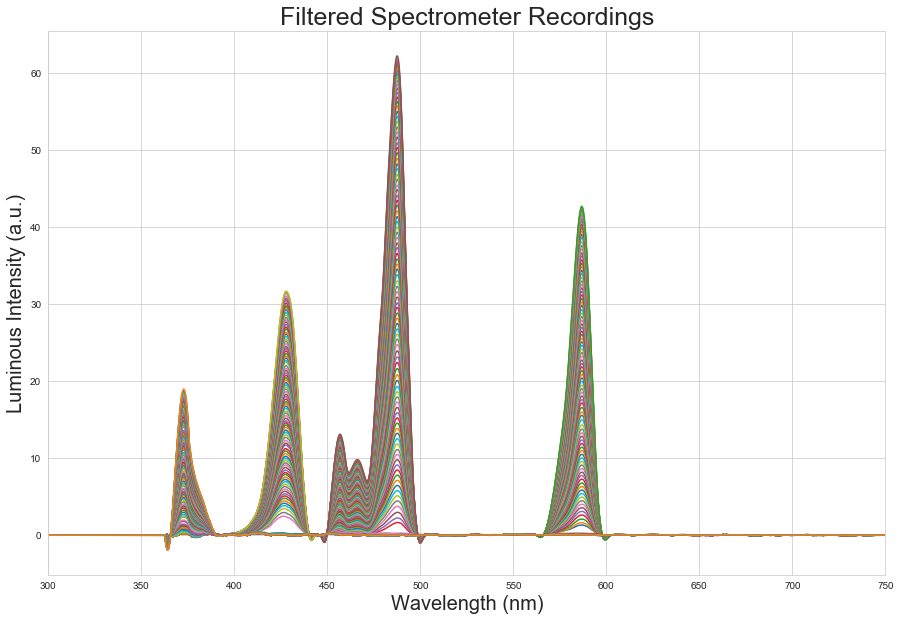

In [4]:
# Use a Savitzky–Golay filter to smooth the recorded "Spectra" traces

savgolWindow = 61   # The length of the filter window
savgolOrder = 2     # The order of the polynomial used to fit the samples.
savgolDelta = 1     # The spacing of the samples to which the filter will be applied.

Smoothed = savgol(Spectra, savgolWindow, savgolOrder, delta = savgolDelta, axis = -1)
Smoothed = Smoothed.reshape(nLED,nPoints,-1)
Smoothed = Smoothed[:,:-7,:]

fig,ax = plt.subplots(1,1,figsize = FigureSize)
[ax.plot(WvsX,Smoothed[0,i,:]) for i in range(Smoothed.shape[1])]
[ax.plot(WvsX,Smoothed[1,i,:]) for i in range(Smoothed.shape[1])]
[ax.plot(WvsX,Smoothed[2,i,:]) for i in range(Smoothed.shape[1])]
[ax.plot(WvsX,Smoothed[3,i,:]) for i in range(Smoothed.shape[1])]

ax.set_title('Filtered Spectrometer Recordings', fontsize = FigureTitleSize)
ax.set_xlabel('Wavelength (nm)', fontsize = FigureFontSize)
ax.set_ylabel('Luminous Intensity (a.u.)', fontsize = FigureFontSize)
ax.set_xlim((SpectraRange))

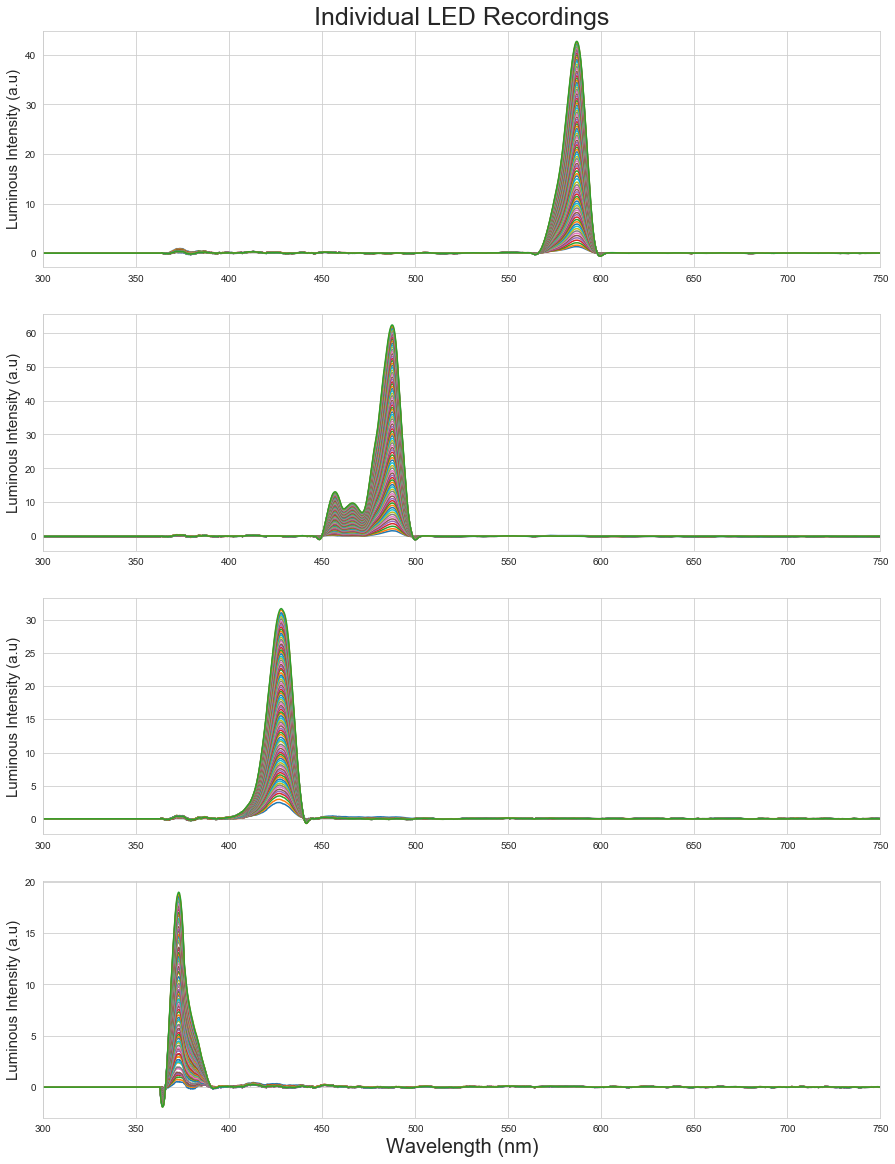

In [5]:
# Plot all recorded LED intensity value individually

fig,ax = plt.subplots(4,1,figsize = (15,20))

[ax[0].plot(WvsX,Smoothed[0,i,:]) for i in range(Smoothed.shape[1])];
[ax[1].plot(WvsX,Smoothed[1,i,:]) for i in range(Smoothed.shape[1])];
[ax[2].plot(WvsX,Smoothed[2,i,:]) for i in range(Smoothed.shape[1])];
[ax[3].plot(WvsX,Smoothed[3,i,:]) for i in range(Smoothed.shape[1])];


[ax[0].set_title('Individual LED Recordings', fontsize = FigureTitleSize)]
[ax[i].set_xlabel('Wavelength (nm)', fontsize = FigureFontSize) for i in [3]]
[ax[i].set_ylabel('Luminous Intensity (a.u)', fontsize = 15) for i in [0,1,2,3]]

[ax[i].set_xlim(SpectraRange) for i in [0,1,2,3]];

In [6]:
# Determine peak wavelength for each LED in nm

sm = 80
MaxesIndices = np.argmax(Smoothed[:,sm,:],axis = -1)

Peaks = WvsX[MaxesIndices]
Peaks = np.around(Peaks,decimals=1)

Peak = [['','Red ','Green ','Blue ','UV '],
        ['Peak Wavelength (nm)',Peaks[0],Peaks[1],Peaks[2],Peaks[3]],
        ]

display(HTML(
   '<table><tr>{}</tr></table>'.format(
       '</tr><tr>'.join(
           '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in Peak)
       )
))

,Red,Green,Blue,UV
Peak Wavelength (nm),586.9,487.5,427.9,372.8


In [7]:
# Setting functions and parameters to establish LED performances

def linfunc(x,param):
    a,b = param
    return a+b*x

def linfunc_error(param,x,y):
    """x is current, param is a vector of length 2, y is all luminescence values"""
    y_pred = linfunc(x,param)
    return np.sum((y-y_pred)**2)/y.shape[0]

def norm (myarray):
    myarray = myarray/np.nanmax(np.abs(myarray))
    return myarray

x0 = [1,1] # initial guess for a,b
args = (np.arange(1,94),np.sum(Smoothed[0,:,:],axis=-1))
argss = (np.arange(1,94),np.sum(Smoothed[1,:,:],axis=-1))
argsss = (np.arange(1,94),np.sum(Smoothed[2,:,:],axis=-1))
argssss = (np.arange(1,94),np.sum(Smoothed[3,:,:],axis=-1))


RedSolution = minimize(linfunc_error, x0 = x0, args = args).x
GreenSolution = minimize(linfunc_error, x0 = x0, args = argss).x
BlueSolution = minimize(linfunc_error, x0 = x0, args = argsss).x
UVSolution = minimize(linfunc_error, x0 = x0, args = argssss).x

SSE_Red = np.sqrt(linfunc_error(RedSolution, args[0], args[1]))
SSE_Red = np.around(SSE_Red,decimals=2)
SSE_Green = np.sqrt(linfunc_error(GreenSolution, args[0], args[1]))
SSE_Green = np.around(SSE_Red,decimals=2)
SSE_Blue = np.sqrt(linfunc_error(BlueSolution, args[0], args[1]))
SSE_Blue = np.around(SSE_Red,decimals=2)
SSE_UV = np.sqrt(linfunc_error(UVSolution, args[0], args[1]))
SSE_UV = np.around(SSE_Red,decimals=2)


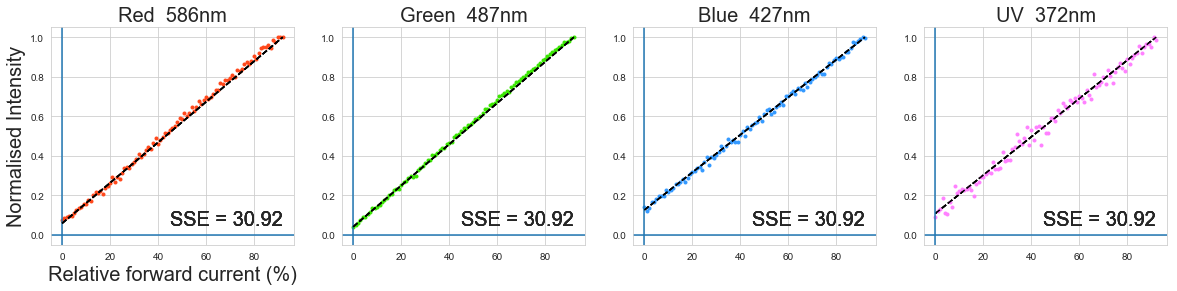

In [8]:
# Plot LEDs intensities (relative output power) against their forward current

fig,ax = plt.subplots(1,nLED,figsize = (20,4))
titles = ['Red  '+str(int(Peaks[0]))+'nm','Green  '+str(int(Peaks[1]))+'nm','Blue  '+str(int(Peaks[2]))+'nm','UV  '+str(int(Peaks[3]))+'nm']
colors = ["#ff471a",'#39e600','#3399ff','#ff80ff']

SSE_Font = 20
SSE_x = 45
SSE_y = 0.05

for i in [0,1,2,3]:
    ax[i].plot(norm(np.sum(Smoothed[i,:,:],axis=-1)),'.',color = colors[i])
    ax[0].plot(norm(linfunc(args[0],RedSolution)),"k--")
    ax[0].text(SSE_x,SSE_y,'SSE = '+str(SSE_Red),fontsize=SSE_Font)
    ax[1].plot(norm(linfunc(args[0],GreenSolution)),"k--")
    ax[1].text(SSE_x,SSE_y,'SSE = '+str(SSE_Green),fontsize=SSE_Font)
    ax[2].plot(norm(linfunc(args[0],BlueSolution)),"k--")
    ax[2].text(SSE_x,SSE_y,'SSE = '+str(SSE_Blue),fontsize=SSE_Font)
    ax[3].plot(norm(linfunc(args[0],UVSolution)),"k--")
    ax[3].text(SSE_x,SSE_y,'SSE = '+str(SSE_UV),fontsize=SSE_Font)
    ax[i].set_title(titles[i], fontsize = FigureFontSize)
    
    ax[0].set_xlabel('Relative forward current (%)', fontsize = FigureFontSize)
    ax[0].set_ylabel('Normalised Intensity', fontsize = FigureFontSize)
    ax[i].axhline()
    ax[i].axvline()

plt.savefig("Normalised Intensity VS Forward Current.png")

C:\Users\Maxime\Anaconda3\lib\site-packages\matplotlib\figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


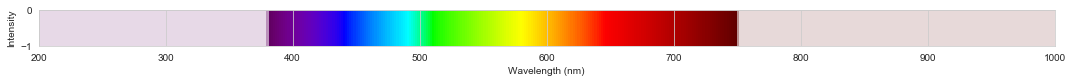

In [9]:
# Setting a "rainbow" gradient that attribute a given wavelentgh (in nm) to its approximate RGB color value

''' This part of the code is taken from http://www.noah.org/wiki/Wavelength_to_RGB_in_Python.

    Based on code by Dan Bruton
    http://www.physics.sfasu.edu/astro/color/spectra.html
    ''' 

def wavelength_to_rgb(wavelength, gamma=0.8):
    wavelength = float(wavelength)
    if wavelength >= 380 and wavelength <= 750:
        A = 1.
    else:
        A=0.15
    if wavelength < 380:
        wavelength = 380.
    if wavelength >750:
        wavelength = 750.
    if wavelength >= 380 and wavelength <= 440:
        attenuation = 0.3 + 0.7 * (wavelength - 380) / (440 - 380)
        R = ((-(wavelength - 440) / (440 - 380)) * attenuation) ** gamma
        G = 0.0
        B = (1.0 * attenuation) ** gamma
    elif wavelength >= 440 and wavelength <= 490:
        R = 0.0
        G = ((wavelength - 440) / (490 - 440)) ** gamma
        B = 1.0
    elif wavelength >= 490 and wavelength <= 510:
        R = 0.0
        G = 1.0
        B = (-(wavelength - 510) / (510 - 490)) ** gamma
    elif wavelength >= 510 and wavelength <= 580:
        R = ((wavelength - 510) / (580 - 510)) ** gamma
        G = 1.0
        B = 0.0
    elif wavelength >= 580 and wavelength <= 645:
        R = 1.0
        G = (-(wavelength - 645) / (645 - 580)) ** gamma
        B = 0.0
    elif wavelength >= 645 and wavelength <= 750:
        attenuation = 0.3 + 0.7 * (750 - wavelength) / (750 - 645)
        R = (1.0 * attenuation) ** gamma
        G = 0.0
        B = 0.0
    else:
        R = 0.0
        G = 0.0
        B = 0.0
    return (R,G,B,A)

clim=(350,780)
norm = plt.Normalize(*clim)
wl = np.arange(clim[0],clim[1]+1,2)
colorlist = list(zip(norm(wl),[wavelength_to_rgb(w) for w in wl]))
spectralmap = matplotlib.colors.LinearSegmentedColormap.from_list("spectrum", colorlist)

fig, axs = plt.subplots(1, 1, figsize=(15,1.25), tight_layout=True)

wavelengths = np.linspace(200, 1000, 1000)
spectrum = (5 + np.sin(wavelengths*0.1)**2) * np.exp(-0.00002*(wavelengths-600)**2)
#plt.plot(wavelengths, spectrum, color='darkred')

y = np.linspace(0, -1, 100)
X,Y = np.meshgrid(wavelengths, y)

extent=(np.min(wavelengths), np.max(wavelengths), np.min(y), np.max(y))

plt.imshow(X, clim=clim,  extent=extent, cmap=spectralmap, aspect='auto')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity')
plt.ylim(-1,0)
plt.fill_between(wavelengths, spectrum,  8, color='w')
plt.savefig('WavelengthColors.png')

plt.show()

(-0.05, 1.01)

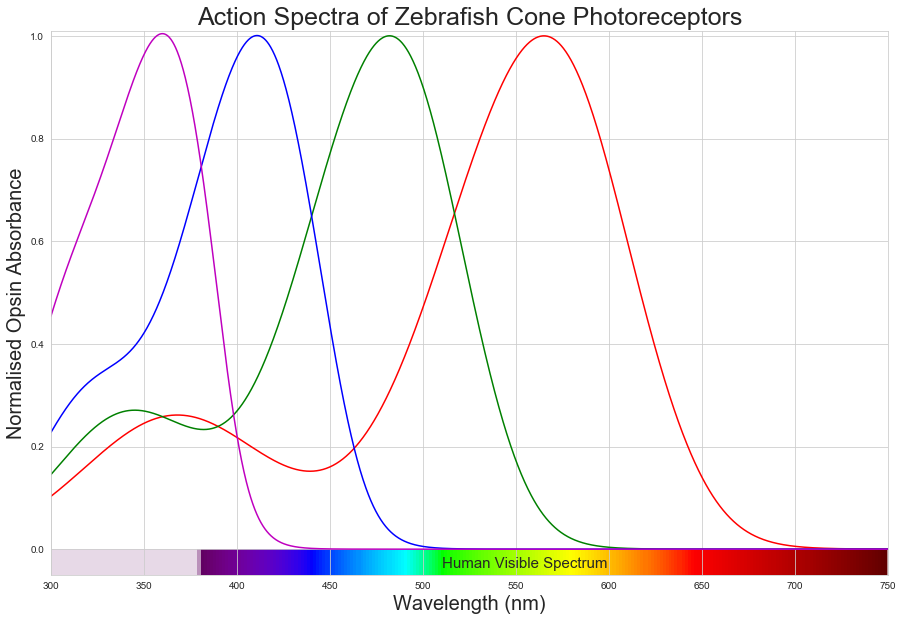

In [10]:
# Plot zebrafish cone opsin absorption spectra

'''This part of the code uses the absorbance spectrum fitting template for visual pigment defined by Govardoskii et al (In 
Search of Visual Pigment Template, 2000).'''

def alphaband (wvsloc, lambdamax):
   """Govardovskii 2000 alpha band template. This function returns one sensitivity spectrum point y at wavelength = wvs
   of an opsin  with a peak at lambdamax,
   wvs - such wavelengths at which the template will be evaluated: 1d-array
   lambdamax - peak of the sensitivity spectrum"""
   wvs = np.asarray(wvsloc)
   A = 69.7
   a = 0.8795+0.0459*np.exp(-np.square(lambdamax-300)/11940)
   B = 28
   b = 0.922
   C = -14.9
   c = 1.104
   D = 0.674
   x = lambdamax/wvs
   alphaband = 1/ (np.exp(A*(a-x))+np.exp(B*(b-x))+np.exp(C*(c-x))+D)
   
   #####BETABAND######
   Ab = 0.26 #Beta value at peak
   b = -40.5+0.195*lambdamax #Beta bandwidth
   Lamb = 189+0.315*lambdamax #Beta peak
   betaband = Ab * np.exp(-1*((wvs-Lamb)/b)**2)
   return alphaband+betaband


red = alphaband(WvsX,peakwvss[0])
green = alphaband(WvsX,peakwvss[1])
blue = alphaband(WvsX,peakwvss[2])
uv = alphaband(WvsX,peakwvss[3])

fig,ax = plt.subplots(1,1,figsize = FigureSize)
ax.plot(WvsX,red,c='r')
ax.plot(WvsX,green,c='g')
ax.plot(WvsX,blue,c='b')
ax.plot(WvsX,uv,c='m')

ax.set_title('Action Spectra of Zebrafish Cone Photoreceptors', fontsize = FigureTitleSize)
ax.set_xlabel('Wavelength (nm)', fontsize = FigureFontSize)
ax.set_ylabel('Normalised Opsin Absorbance', fontsize = FigureFontSize)

ax.imshow(X, clim=clim,  extent=extent, cmap=spectralmap, aspect = 'auto')
plt.text(510, -0.0375, 'Human Visible Spectrum', fontsize=15)

ax.set_xlim(SpectraRange)
ax.set_ylim(-0.05,1.01)

(-0.05, 1.01)

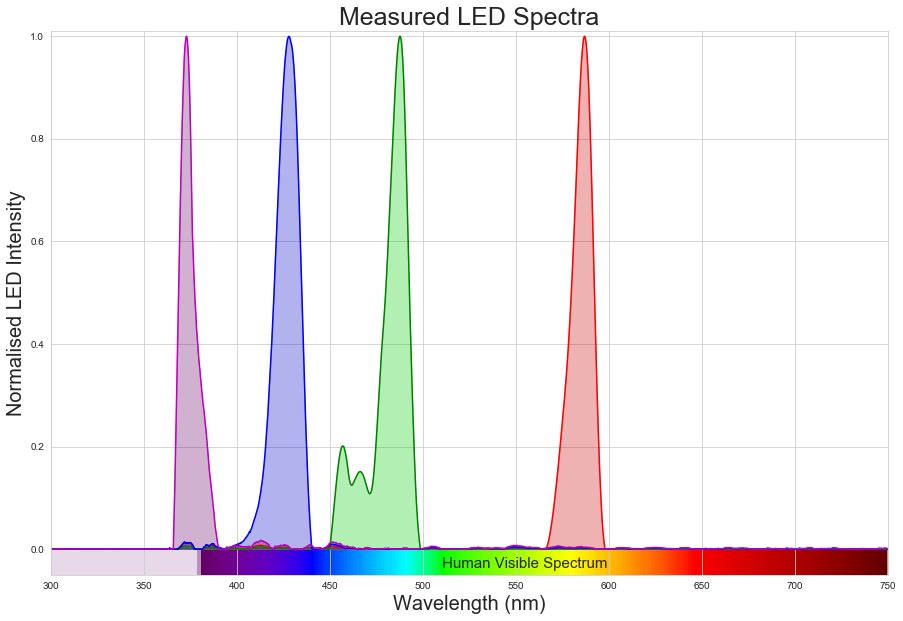

In [11]:
# Plot LED spectra

RedLEDNormalised = Smoothed[0,sm,:]/np.amax(Smoothed[0,sm,:])
GreenLEDNormalised = Smoothed[1,sm,:]/np.amax(Smoothed[1,sm,:])
BlueLEDNormalised = Smoothed[2,sm,:]/np.amax(Smoothed[2,sm,:])
UVLEDNormalised = Smoothed[3,sm,:]/np.amax(Smoothed[3,sm,:])

RedLEDnormalised = np.copy(RedLEDNormalised)
RedLEDnormalised[RedLEDnormalised<0] = 0
GreenLEDnormalised = np.copy(GreenLEDNormalised)
GreenLEDnormalised[GreenLEDnormalised<0] = 0
BlueLEDnormalised = np.copy(BlueLEDNormalised)
BlueLEDnormalised[BlueLEDnormalised<0] = 0
UVLEDnormalised = np.copy(UVLEDNormalised)
UVLEDnormalised[UVLEDnormalised<0] = 0

fig,ax = plt.subplots(1,1,figsize = FigureSize)
ax.plot(WvsX,RedLEDnormalised,'r')
ax.fill(WvsX,RedLEDnormalised, c = (0.8,0.0,0.0,0.3))
ax.plot(WvsX,GreenLEDnormalised,'g')
ax.fill(WvsX,GreenLEDnormalised, c = (0.0,0.8,0.0,0.3))
ax.plot(WvsX,BlueLEDnormalised,'b')
ax.fill(WvsX,BlueLEDnormalised, c = (0.0,0.0,0.8,0.3))
ax.plot(WvsX,UVLEDnormalised,'m')
ax.fill(WvsX,UVLEDnormalised, c = (0.4,0.0,0.4,0.3))

ax.set_title('Measured LED Spectra', fontsize = FigureTitleSize)
ax.set_xlabel('Wavelength (nm)', fontsize = FigureFontSize)
ax.set_ylabel('Normalised LED Intensity', fontsize = FigureFontSize)

ax.imshow(X, clim=clim,  extent=extent, cmap=spectralmap, aspect = 'auto')
plt.text(510, -0.0375, 'Human Visible Spectrum', fontsize=15)

ax.set_xlim(SpectraRange)
ax.set_ylim(-0.05,1.01)

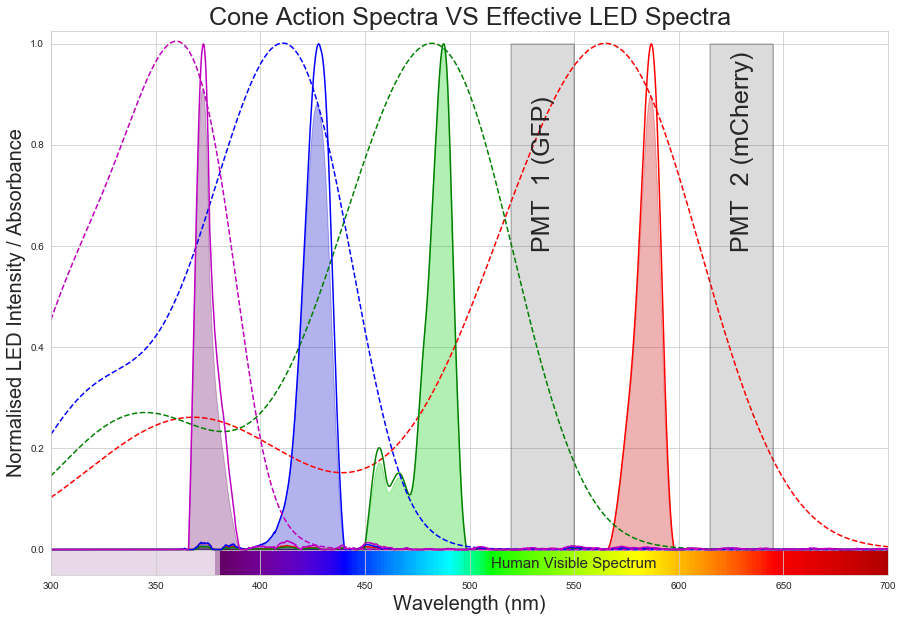

In [14]:
# Plot LED spectra against the zebrafish cone action spectra. Graph includes the PMT detector bands

fig,ax = plt.subplots(1,1,figsize = FigureSize)


RedLEDnormalised = np.copy(RedLEDNormalised)
RedLEDnormalised[RedLEDnormalised<0] = 0
GreenLEDnormalised = np.copy(GreenLEDNormalised)
GreenLEDnormalised[GreenLEDnormalised<0] = 0
BlueLEDnormalised = np.copy(BlueLEDNormalised)
BlueLEDnormalised[BlueLEDnormalised<0] = 0
UVLEDnormalised = np.copy(UVLEDNormalised)
UVLEDnormalised[UVLEDnormalised<0] = 0

ax.plot(WvsX,red,'r--')
ax.plot(WvsX,RedLEDnormalised,'r')
ax.fill(WvsX,np.multiply(red,RedLEDnormalised), c = (0.8,0.0,0.0,0.3))

ax.plot(WvsX,green,'g--')
ax.plot(WvsX,GreenLEDnormalised,'g')
ax.fill(WvsX,np.multiply(green,GreenLEDnormalised), c = (0.0,0.8,0.0,0.3))

ax.plot(WvsX,blue,'b--')
ax.plot(WvsX,BlueLEDnormalised,'b')
ax.fill(WvsX,np.multiply(blue,BlueLEDnormalised), c = (0.0,0.0,0.8,0.3))

ax.plot(WvsX,uv,'m--')
ax.plot(WvsX,UVLEDnormalised,'m')
ax.fill(WvsX,np.multiply(uv,UVLEDnormalised), c = (0.4,0.0,0.4,0.3))

ax.set_xlim(SpectraRange)
ax.set_ylim(-0.05,1.025)

plt.plot([PMT1_min,PMT1_min,PMT1_max,PMT1_max], [0,1,1,0], c = (0.3,0.3,0.3,0.3))
ax.fill([PMT1_min,PMT1_min,PMT1_max,PMT1_max], [0,1,1,0], c = (0.3,0.3,0.3,0.2))
plt.text(PMT1_min+10, 0.66+0.2, 'PMT  1 (GFP)', fontsize=25, rotation=90)

plt.plot([PMT2_min,PMT2_min,PMT2_max,PMT2_max], [0,1,1,0], c = (0.3,0.3,0.3,0.3))
ax.fill([PMT2_min,PMT2_min,PMT2_max,PMT2_max], [0,1,1,0], c = (0.3,0.3,0.3,0.2))
plt.text(PMT2_min+10, 0.749+0.2, 'PMT  2 (mCherry)', fontsize=25, rotation=90)

ax.set_title('Cone Action Spectra VS Effective LED Spectra', fontsize = FigureTitleSize)
plt.xlabel('Wavelength (nm)', fontsize = FigureFontSize)
plt.ylabel('Normalised LED Intensity / Absorbance', fontsize = FigureFontSize)

ax.imshow(X, clim=clim,  extent=extent, cmap=spectralmap, aspect = 'auto')
plt.text(510, -0.0375, 'Human Visible Spectrum', fontsize=15)

plt.savefig("Opsin-LED Spectra.png")